# Modelamiento

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
!pip install surprise

In [16]:
!pip install dask-ml

In [17]:
# Imports
import dask.dataframe as dd
import pandas as pd
import numpy as np
from surprise import accuracy, Dataset, Reader
from surprise.model_selection import train_test_split, GridSearchCV
from surprise.prediction_algorithms.knns import KNNBasic
from collections import defaultdict
from surprise.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
datos = dd.read_parquet('/content/drive/MyDrive/EAFIT/Semestre 3/Mineria de grandes Volumenes de Datos/Proyecto Integrador/data1pct.parquet',  engine="pyarrow")

datos.head()

,customer_id,product_id,star_rating
0,24912421,B000A3WS84,5.0
1,22668859,B0032QA93M,5.0
2,29511033,B005HB8JN2,1.0
3,35207047,B00BQ5RYI4,5.0
4,20204904,B00AWJEOFG,5.0


In [19]:
len(datos)

1098284

In [20]:
#De nuevo muestreo al 20%
# Muestrear al 20% del DataFrame
data_model = datos.sample(frac=0.03, random_state=42)

In [21]:
# Convertirlo a un Pandas DataFrame para operar localmente
data_model = data_model.compute()

# Verificar información del DataFrame
data_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32951 entries, 2482 to 3
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  32951 non-null  int64  
 1   product_id   32951 non-null  string 
 2   star_rating  32951 non-null  float64
dtypes: float64(1), int64(1), string(1)
memory usage: 1.3 MB


In [22]:
from surprise import Reader, Dataset

# Crear un objeto Reader con el rango de calificaciones
reader = Reader(rating_scale=(1, 5))  # Calificaciones de 1 a 5

# Cargar datos desde el DataFrame
sdata = Dataset.load_from_df(data_model[['customer_id', 'product_id', 'star_rating']], reader)


In [23]:
# Dividir en entrenamiento y prueba
trainset, testset = train_test_split(sdata, test_size=0.2, random_state=42)

In [24]:
# Configurar similitud para KNNBasic
sim_options = {'name': 'pearson', 'user_based': False}
sim_item_item = KNNBasic(sim_options=sim_options, verbose=False)

In [25]:
# Entrenar el modelo
sim_item_item.fit(trainset)

RMSE: 1.3561
RMSE: 1.3285
RMSE: 1.3262
RMSE: 1.4478
RMSE: 1.3461
RMSE: 1.3857
RMSE: 1.3429
RMSE: 1.3800
RMSE: 1.3425
RMSE: 1.3486
RMSE: 1.3158
RMSE: 1.3216
RMSE: 1.2768
RMSE: 1.2546
RMSE: 1.2575
RMSE: 1.2597
RMSE: 1.2509
RMSE: 1.2574
RMSE: 1.2555
RMSE: 1.2812
RMSE: 1.2571
RMSE: 1.2650
RMSE: 1.2641
RMSE: 1.2640
RMSE: 1.2728
RMSE: 1.2738
RMSE: 1.2985
RMSE: 1.2587
RMSE: 1.2611
RMSE: 1.2501
RMSE: 1.2506
RMSE: 1.2599
RMSE: 1.2656
RMSE: 1.2589
RMSE: 1.2640
RMSE: 1.2734
RMSE: 1.2675
RMSE: 1.2658
RMSE: 1.2685
RMSE: 1.2793
RMSE: 1.2721
RMSE: 1.2621
RMSE: 1.2490
RMSE: 1.2759
RMSE: 1.2644
RMSE: 1.2882
RMSE: 1.2729
RMSE: 1.2733
RMSE: 1.2689
RMSE: 1.2682
RMSE: 1.2909
RMSE: 1.2894
RMSE: 1.2673
RMSE: 1.2776
RMSE: 1.2746
RMSE: 1.2752
RMSE: 1.2702
RMSE: 1.2682
RMSE: 1.2635
RMSE: 1.2675
RMSE: 1.2689
RMSE: 1.2628
RMSE: 1.2648
RMSE: 1.2676
RMSE: 1.2686
RMSE: 1.2692
RMSE: 1.2701
RMSE: 1.2770
RMSE: 1.2585
RMSE: 1.2584
RMSE: 1.2736
RMSE: 1.2695
RMSE: 1.2671
RMSE: 1.2795
RMSE: 1.2749
RMSE: 1.2677
RMSE: 1.2754

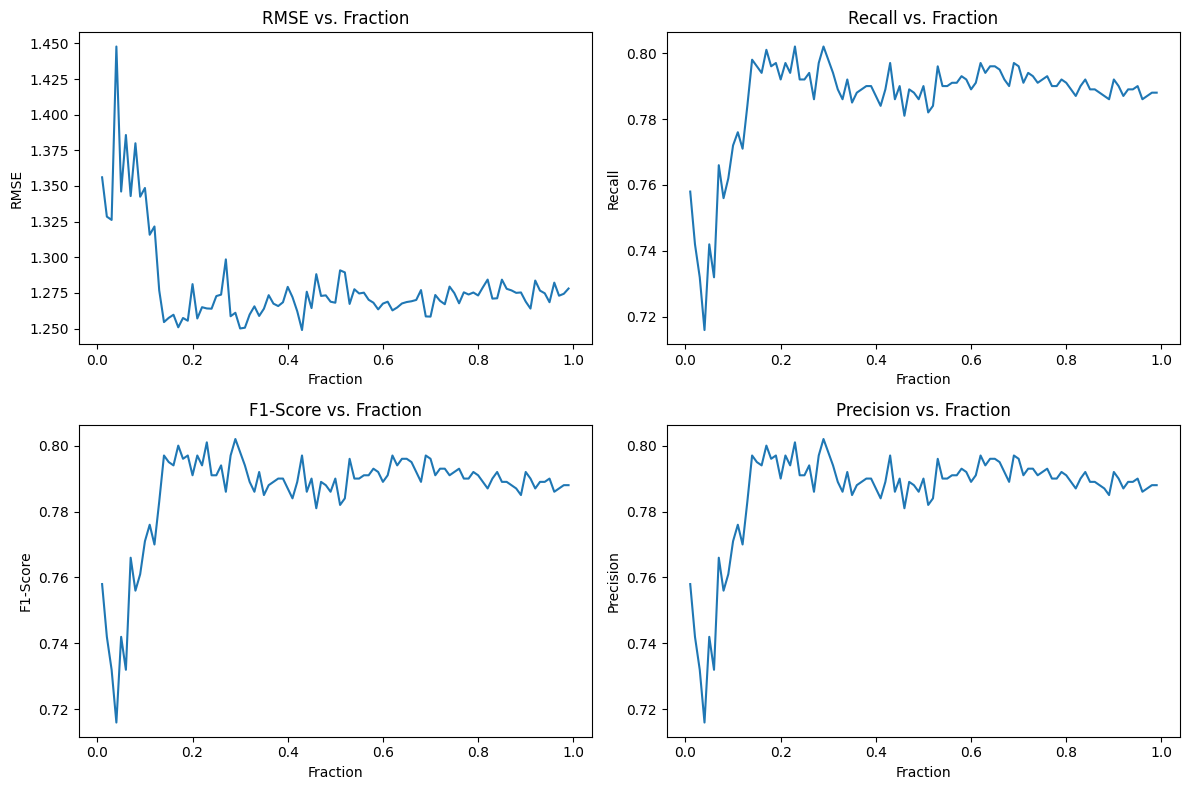

In [27]:
def evaluate_model_with_fractions(data_model, fractions):
    rmse_scores = []
    recall_scores = []
    f1_scores = []
    precision_scores = []

    for frac in fractions:
        # Muestrear el DataFrame
        sampled_data = data_model.sample(frac=frac, random_state=42)
        sampled_data = sampled_data#.compute()

        # Cargar datos desde el DataFrame
        reader = Reader(rating_scale=(1, 5))
        sdata = Dataset.load_from_df(sampled_data[['customer_id', 'product_id', 'star_rating']], reader)

        # Dividir en entrenamiento y prueba
        trainset, testset = train_test_split(sdata, test_size=0.2, random_state=42)

        # Configurar similitud para KNNBasic
        sim_options = {'name': 'pearson', 'user_based': False}
        sim_item_item = KNNBasic(sim_options=sim_options, verbose=False)

        # Entrenar el modelo
        sim_item_item.fit(trainset)

        # Evaluar y obtener métricas
        predictions = sim_item_item.test(testset)
        rmse = accuracy.rmse(predictions)

        precision, recall, f1 = precision_recall_at_k(sim_item_item, testset)

        rmse_scores.append(rmse)
        recall_scores.append(recall)
        f1_scores.append(f1)
        precision_scores.append(precision)

    return rmse_scores, recall_scores, f1_scores, precision_scores

def precision_recall_at_k(model, testset, k=10, threshold=3.5):
    predictions = model.test(testset)
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    precision = round(sum(prec for prec in precisions.values()) / len(precisions), 3)
    recall = round(sum(rec for rec in recalls.values()) / len(recalls), 3)
    f1_score = round(2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0, 3)
    return precision, recall, f1_score


# Fracciones
fractions = np.arange(0.01, 1.0, 0.01) #Fracciones de 0.001 a 0.04
rmse_scores, recall_scores, f1_scores, precision_scores = evaluate_model_with_fractions(data_model, fractions)


plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(fractions, rmse_scores)
plt.xlabel('Fraction')
plt.ylabel('RMSE')
plt.title('RMSE vs. Fraction')

plt.subplot(2, 2, 2)
plt.plot(fractions, recall_scores)
plt.xlabel('Fraction')
plt.ylabel('Recall')
plt.title('Recall vs. Fraction')

plt.subplot(2, 2, 3)
plt.plot(fractions, f1_scores)
plt.xlabel('Fraction')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Fraction')

plt.subplot(2, 2, 4)
plt.plot(fractions, precision_scores)
plt.xlabel('Fraction')
plt.ylabel('Precision')
plt.title('Precision vs. Fraction')

plt.tight_layout()
plt.show()